### Import libraries

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime

# check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# created date
print("Created date: 2023-07-05 16:00:17")
# modified date
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Modified date: {now}")

PyTorch version: 1.12.1+cu102
Device: cuda
Created date: 2023-07-05 16:00:17
Modified date: 2023-07-06 10:41:21


#### Dataset

In [3]:
# get data to calculate mean and standard deviation
transform = transforms.Compose([transforms.ToTensor()])
train_set = FashionMNIST("../../data", download=True, train= True, transform=transform)
train_loader = DataLoader(train_set, batch_size=len(train_set), shuffle=True)
# iter
data = next(iter(train_loader))

# calculate mean, std
mean = data[0].mean()
std =  data[0].std()

print(f"Mean: {mean.numpy()}, Std: {std.numpy()}")

Mean: 0.28604060411453247, Std: 0.3530242443084717


In [4]:
len(data[0])

60000

In [5]:
# transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

# training set
train_set = FashionMNIST("../../data", download=True, train= True, transform=transform)

# testing set
test_set = FashionMNIST("../../data", download=True, train= False, transform=transform)

In [6]:
# class names
class_names = train_set.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
# check length of training set, testing set
len(train_set), len(test_set)

(60000, 10000)

#### Modeling

In [8]:
# FashionMNIST Neural Network
class FashionMNISTNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layers = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features= 256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features= 128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features= 64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features= 10),
        )
    def forward(self, x):
        return self.layers(x)

In [9]:
# set manual seed
torch.manual_seed(42)

# create an instance of the model
fashionMNIST_model = FashionMNISTNN()

# init weights and bias
for module in fashionMNIST_model.modules():
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.constant_(module.bias, 0.0)

# copy the model to device
fashionMNIST_model.to(device)

FashionMNISTNN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [10]:
# batch_size
batch_size = 16

# dataloader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# epochs 
epochs = 20

# loss_fn
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params=fashionMNIST_model.parameters(), lr=0.0022)

In [11]:
# start training
for epoch in range(epochs):

    accumulated_train_batches = 0
    accumulated_train_acc = 0.0
    accumulated_train_loss = 0.0

    ### TRAINING
    for inputs, targets in train_loader:

        # copy inputs, targets to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # train mode
        fashionMNIST_model.train()

        # forward pass
        y_logits = fashionMNIST_model(inputs)

        # calculate loss 
        loss = loss_fn(y_logits, targets)

        # accumulate loss
        accumulated_train_loss += loss

        # calculate accuracy
        acc = torch.eq(targets, torch.argmax(torch.softmax(y_logits, axis=1), axis=1)).sum().item()
        accumulated_train_acc += acc

        # set zero gradients
        optimizer.zero_grad()

        # backpropagation 
        loss.backward()

        # update weights, bias
        optimizer.step()

        # accumulate batches
        accumulated_train_batches += 1

    train_loss = accumulated_train_loss / accumulated_train_batches
    train_acc = accumulated_train_acc / (accumulated_train_batches * batch_size)


    ### TESTING 
    fashionMNIST_model.eval()
    with torch.inference_mode():

        accumulated_test_batches = 0
        accumulated_test_acc = 0.0
        accumulated_test_loss = 0.0

        for inputs, targets in test_loader:

            # copy inputs, targets to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass
            y_logits = fashionMNIST_model(inputs)

            # calculate loss 
            loss = loss_fn(y_logits, targets)

            # accumulate loss
            accumulated_test_loss += loss

            # calculate accuracy
            acc = torch.eq(targets, torch.argmax(torch.softmax(y_logits, axis=1), axis=1)).sum().item()
            accumulated_test_acc += acc

            # accumulate batches
            accumulated_test_batches += 1

        test_loss = accumulated_test_loss / accumulated_test_batches
        test_acc = accumulated_test_acc / (accumulated_test_batches * batch_size)


    print(f"Epoch: {epoch + 1} / {epochs} | Train loss: {train_loss: .5f} | Train acc: {train_acc: .2f} |  Test loss: {test_loss: .5f} | Test acc: {test_acc: .2f}")


Epoch: 1 / 20 | Train loss:  0.49942 | Train acc:  0.82 |  Test loss:  0.00057 | Test acc:  0.83
Epoch: 2 / 20 | Train loss:  0.39425 | Train acc:  0.86 |  Test loss:  0.00074 | Test acc:  0.83
Epoch: 3 / 20 | Train loss:  0.36842 | Train acc:  0.87 |  Test loss:  0.00048 | Test acc:  0.86
Epoch: 4 / 20 | Train loss:  0.34909 | Train acc:  0.87 |  Test loss:  0.00027 | Test acc:  0.86
Epoch: 5 / 20 | Train loss:  0.33627 | Train acc:  0.88 |  Test loss:  0.00043 | Test acc:  0.86
Epoch: 6 / 20 | Train loss:  0.32428 | Train acc:  0.88 |  Test loss:  0.00019 | Test acc:  0.86
Epoch: 7 / 20 | Train loss:  0.31313 | Train acc:  0.89 |  Test loss:  0.00022 | Test acc:  0.87
Epoch: 8 / 20 | Train loss:  0.30555 | Train acc:  0.89 |  Test loss:  0.00045 | Test acc:  0.87
Epoch: 9 / 20 | Train loss:  0.30162 | Train acc:  0.89 |  Test loss:  0.00023 | Test acc:  0.86
Epoch: 10 / 20 | Train loss:  0.29934 | Train acc:  0.89 |  Test loss:  0.00010 | Test acc:  0.86
Epoch: 11 / 20 | Train loss: 

In [12]:
# predictions
# test set
test_data = test_set.test_data
test_labels = test_set.test_labels

# evaluation mode
fashionMNIST_model.eval()
with torch.inference_mode():
    y_logits = fashionMNIST_model(test_set.test_data.type(torch.float32).to(device))
    y_preds = torch.argmax(torch.softmax(y_logits, axis=1), axis= 1)

y_preds[:10], test_labels[:10]


/home/jason/anaconda3/envs/tadac/lib/python3.8/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/jason/anaconda3/envs/tadac/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


(tensor([9, 2, 1, 1, 6, 1, 4, 4, 5, 7], device='cuda:0'),
 tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]))

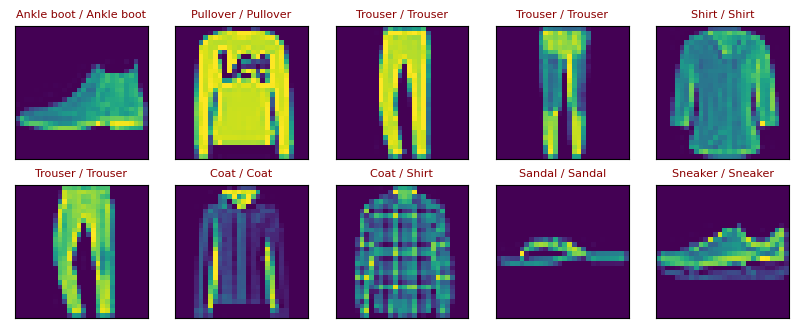

In [13]:
# visualise
plt.figure(figsize=(10,10))
for i in range(0, 10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_data[i])
    plt.title(f"{class_names[y_preds[i]]} / {class_names[test_labels[i]]}", fontdict={"color": "darkred", "size": 8})
    plt.xticks([])
    plt.yticks([])

#### Metrics

In [17]:
# calculate tp, tn, fp, fn
mnist_confusion_matrix = confusion_matrix(y_true=test_labels, y_pred=y_preds.cpu())

mnist_confusion_matrix

array([[859,   3,  41,  27,   6,   0,  21,   0,  43,   0],
       [  3, 967,   6,  11,   1,   0,   3,   0,   9,   0],
       [ 48,   5, 658,   9, 219,   2,  14,   0,  45,   0],
       [ 97,  11,  43, 766,  27,   0,   5,   0,  51,   0],
       [  6,   3, 127,  48, 664,   0,  11,   0, 141,   0],
       [  2,   0,   1,   0,   0, 895,   1,   9,  61,  31],
       [236,   4, 185,  17, 335,   0, 117,   0, 106,   0],
       [  0,   0,   0,   0,   0,  51,   0, 721, 160,  68],
       [  4,   0,   0,   2,   2,   0,   1,   1, 989,   1],
       [  0,   0,   0,   0,   0,  28,   0,  10,  52, 910]])